Single spillover (non-recurrent) with finite population and death

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#class representing one simulation.
#an instance of this class contains enough information to plot some pictures.
#the return value for sim_class and for recurrent_sim_class is an instance of this class. 

class Sim:
    def __init__(self, outcome, times, betas, gammas, N_infecteds, deltas=None, spillover_ids=None, S=None, D=None):
        
        #0 if extinction, 1 if outbreak, None otherwise. 
        #(note sim_class will always return 0 or 1 here, but recurrent_sim_class may return None)
        self.outcome = outcome 
        
        #the number of events in the simulation
        self.length = len(times) # note this is = len(self.betas) = len(self.gammas)= len(self.N)
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.N = N_infecteds #the number of infecteds, inclusive of the new event
        self.spillover_ids = spillover_ids #which spillover tree each event belongs to. the spillover trees ids are integers beginning with 0
        self.deltas = deltas
        self.S = S
        self.D = D
    
        if spillover_ids is None: #if there are no ids, assume they are all part of the same tree, so make them all 0.
            self.spillover_ids = np.zeros(self.length)
            
            
    
    #returns the ith event [t, beta, gamma, N]
    def event(self, i):
        return np.array([self.times[i], self.betas[i], self.gammas[i], self.N[i]])
    
    #truncate everything after time t_thresh
    def truncate(self, t_thresh):      
        for i in range(self.length()):
            if self.times[i] > t_thresh:
                self.times = self.times[:i]
                self.betas = self.betas[:i]
                self.gammas = self.gammas[:i]
                self.N = self.N[:i]
                break
        

In [7]:
#############################################################
# version of sim which 
#    1. is implemented in "time order" instead of "generation order"
#        (this makes it slower to run, but it's needed in order to make accurate plots)
#    2. returns an element of the class Sim.
#    3. distinguishes between recovery (gamma) and death (deltas).
#############################################################

def sim_death_class(beta_0, gamma_0, delta_0, mu_1=0, mu_2=0, mu_3=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    t=0
        
    #stuff to fill and return as part of Sim object.
    all_times = np.array([t])
    all_betas = np.array([beta_0])
    all_gammas = np.array([gamma_0])
    all_deltas = np.array([delta_0])
    all_N = np.array([1])
    
    N = 1 #initialize variable to keep track of total number of infected
        
    #initialize variables to keep track of sums of beta, gamma, and delta over all currently infected people    
    beta_sum = beta_0; gamma_sum = gamma_0; delta_sum = delta_0
        
    #initialize matrix of active cases. each case is a row of length 4.
    # each row looks like [beta, gamma, delta, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, delta_0, t]])
    
    while True:
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]; gammas = infecteds[:,1]; deltas = infecteds[:,2]
        
        #compute interevent time (for the whole population)
        
        #rate of events is sum of beta and gamma and delta over all infected people
        overall_rate = beta_sum + gamma_sum + delta_sum
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #figure out who the event happened to
        i = np.random.choice(N, p=(betas+gammas+deltas)/overall_rate) #index of that person
        
        #grab their specific beta and gamma and delta
        beta = betas[i]; gamma = gammas[i]; delta = deltas[i]
        
        #figure out what they did, transmit, recover, or die
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = beta / (beta + gamma + delta) #probability of transmission
        prob_recovery = gamma / (beta + gamma + delta)
        
        if (ev < prob_trans): #transmission

            #pick beta, gamma, and delta for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2 or mu_3
            #don't allow negative beta.
            #don't allow gamma to be negative. 
            #don't allow delta to be less than a small value, the natural death rate.
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)
            new_gamma = max(0, gamma + mut2)
            mut3 = np.random.normal(loc=0.0, scale=mu_3)              
            nat_death = 0.00002366575 #taken from CDC: 
                #https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
            new_delta = max(nat_death, delta + mut3)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, new_delta, t]], axis=0)
            
            #update the sums of beta and gamma
            beta_sum += new_beta; gamma_sum += new_gamma; delta_sum += new_delta
            
            #update N
            N += 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, new_beta)
            all_gammas = np.append(all_gammas, new_gamma)
            all_deltas = np.append(all_deltas, new_delta)
            all_N = np.append(all_N, N)

            #check if we have an outbreak
            if N >= outbreak_thresh:
                #print("\n", "outbreak!")
                return Sim(1, all_times, all_betas, all_gammas, all_N, deltas = all_deltas)
    
        elif (ev < prob_trans + prob_recovery): #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta and gamma
            beta_sum -= beta; gamma_sum -= gamma; delta_sum -= delta
            
            #update N
            N -= 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_deltas = np.append(all_deltas, None)
            all_N = np.append(all_N, N)

            #check if we have extinction       
            if N == 0:
                #print("\n", "extinction")
                return Sim(0, all_times, all_betas, all_gammas, all_N, deltas = all_deltas)
            
        else: #death
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta and gamma
            beta_sum -= beta; gamma_sum -= gamma; delta_sum -= delta
            
            #update N
            N -= 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_deltas = np.append(all_deltas, None)
            all_N = np.append(all_N, N)

            #check if we have extinction       
            if N == 0:
                #print("\n", "extinction")
                return Sim(0, all_times, all_betas, all_gammas, all_N, deltas = all_deltas)

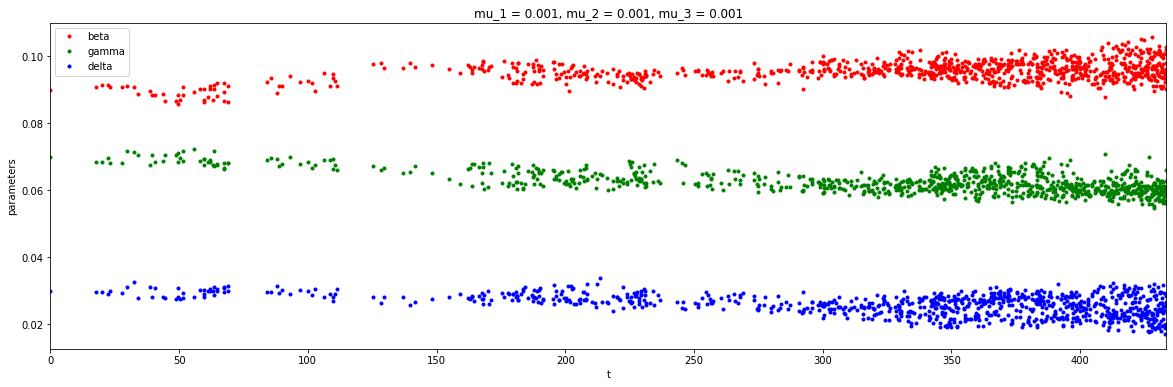

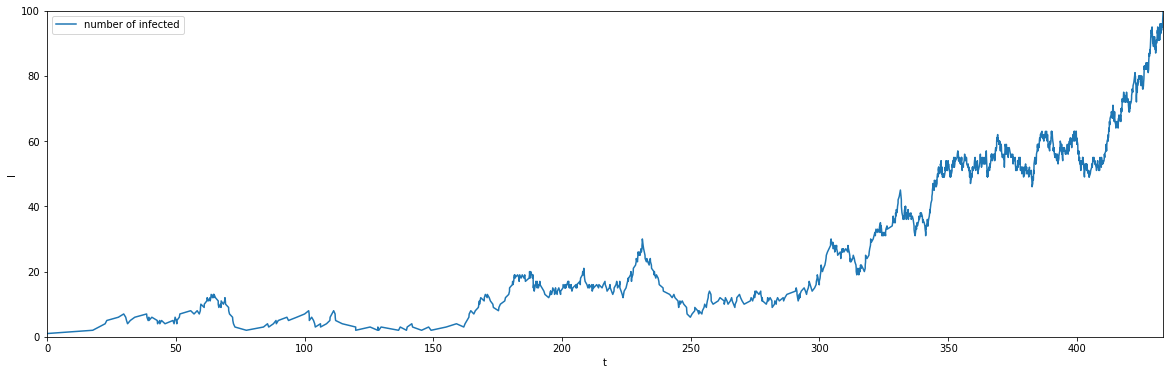

In [8]:
#parameters
beta_0 = 0.09
gamma_0 = 0.07
delta_0 = 0.03
mu_1 = 0.001
mu_2 = 0.001
mu_3 = 0.001

s = None

while True:
    s = sim_death_class(beta_0, gamma_0, delta_0, mu_1, mu_2, mu_3)
    if s.outcome == 1: break #get an outbreak
    #if s.times[-1] > 500: break #get a simulation where the disease spreads for at least this many days
        
times = s.times; betas = s.betas; gammas = s.gammas; deltas = s.deltas; N_infecteds = s.N

#plot betas and gammas and deltas over time
plt.figure(figsize=(20,6))
plt.plot(times, betas, ".r", label='beta')
plt.plot(times, gammas, ".g", label='gamma')
plt.plot(times, deltas, ".b", label='delta')
plt.title('mu_1 = {}, mu_2 = {}, mu_3 = {}'.format(mu_1, mu_2, mu_3))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()

#plot N_infecteds over time
plt.figure(figsize=(20,6))
plt.plot(times, N_infecteds, label='number of infected')
plt.xlabel("t"); plt.ylabel("I")
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0, 100)
plt.legend(); plt.show()